In [25]:
import os
import cv2
import numpy as np
import collections
import pandas as pd
from extract_features import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn import svm, grid_search
from sklearn.externals import joblib
from moviepy.editor import VideoFileClip
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

%matplotlib inline
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## [skimage.feature.hog](http://scikit-image.org/docs/dev/api/skimage.feature.html?highlight=feature%20hog#skimage.feature.hog)
## [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
## [train_and_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
## [np.nonzero( )](https://docs.scipy.org/doc/numpy/reference/generated/numpy.nonzero.html)

### General Formula of number of windows:
windows_x = 1 + (image_width - window_width)/(window_width * overlap_proportion)

windows_y = 1 + (image_height - window_height)/(window_height * overlap_proportion)

total_windows = windows_x * windows_y

# Data preprocessing

## Read  part of GTI dataset and KITTI dataset

In [15]:
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features

### Create image path

In [16]:
car_list = glob.glob('datasets/vehicles/**/*.png')
ncar_list = glob.glob('datasets/non-vehicles/**/*.png')
print(len(car_list), len(ncar_list))

8792 8968


### Extract features with normal images and flipped images

In [17]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

car_features = extract_features(car_list, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(ncar_list, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)

X = np.vstack((car_features, notcar_features)).astype(np.float64) 

y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split to train and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

# Train the SVM
### Search for the SVM's best choice of parameters

In [19]:
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svr = svm.SVC()
clf = grid_search.GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

print("The best choice of parameter: {}".format(clf.best_params_))

The best choice of parameter: {'kernel': 'linear', 'C': 1}


In [20]:
# svc = svm.LinearSVC()
svc = svm.SVC(C=1, kernel='linear', probability=True)
svc.fit(X_train, y_train)

print('Test Accuracy of SVC = ', svc.score(X_test, y_test))
# save model
joblib.dump(svc, './SVC/svc_2.pkl') 

Test Accuracy of SVC =  0.981981981982


['./SVC/svc_2.pkl']

# Find the best searching regions

Number of boxes:  78


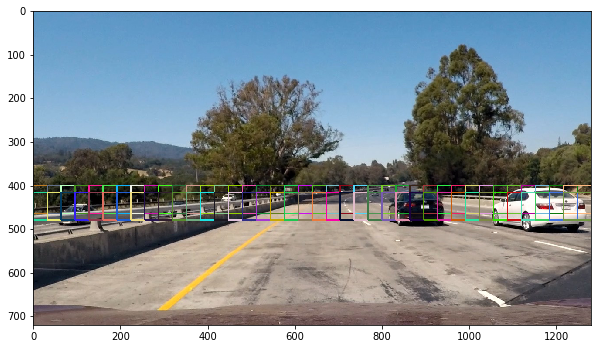

In [26]:
# Test Image 1
svc = joblib.load('./SVC/svc_2.pkl') 
# X_scaler = joblib.load('./SVC/X_scaler.pkl') 

test_img = mpimg.imread('./test_images/test1.jpg')

colorspace = 'RGB2YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
Orient = 11
Pix_per_cell = 16
Cell_per_block = 2
Hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


bbox = []

ystart = 400
ystop = 465
scale = 1.0
bbox.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=0.6, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=True))
ystart = 415
ystop = 488
scale = 1.0
bbox.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=0.6, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=True))

bbox_list = [item for sublist in bbox for item in sublist] 
test_img_bbox = draw_boxes(test_img, bbox_list, color='random', random_color=True, thickness=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_bbox)
print('Number of boxes: ', len(bbox_list))

Number of boxes:  48


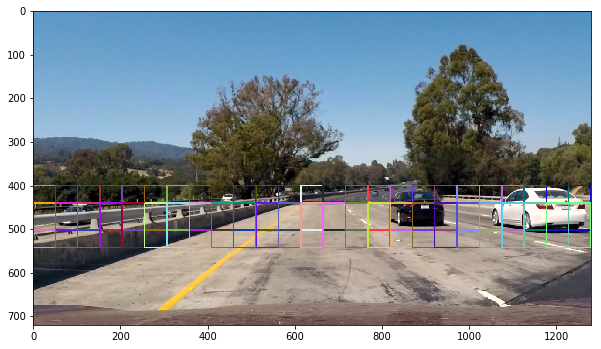

In [27]:
# Test Image 1
svc = joblib.load('./SVC/svc_2.pkl') 
# X_scaler = joblib.load('./SVC/X_scaler.pkl') 

test_img = mpimg.imread('./test_images/test1.jpg')

colorspace = 'RGB2YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
Orient = 11
Pix_per_cell = 16
Cell_per_block = 2
Hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


bbox = []

ystart = 400
ystop = 510
scale = 1.6
bbox.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=0.6, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=True))
ystart = 440
ystop = 550
scale = 1.6
bbox.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=0.6, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=True))

bbox_list = [item for sublist in bbox for item in sublist] 
test_img_bbox = draw_boxes(test_img, bbox_list, color='random', random_color=True, thickness=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_bbox)
print('Number of boxes: ', len(bbox_list))

Number of boxes:  34


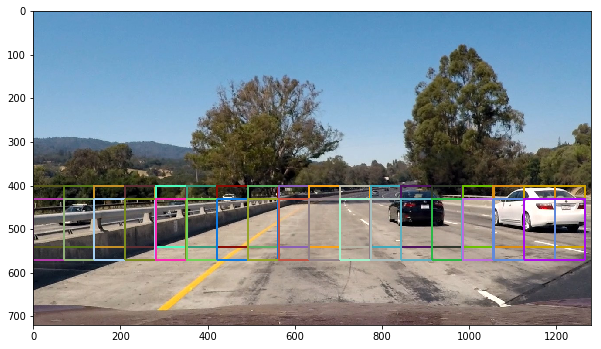

In [28]:
# Test Image 1
svc = joblib.load('./SVC/svc_2.pkl') 
# X_scaler = joblib.load('./SVC/X_scaler.pkl') 

test_img = mpimg.imread('./test_images/test1.jpg')

colorspace = 'RGB2YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
Orient = 11
Pix_per_cell = 16
Cell_per_block = 2
Hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


bbox = []

ystart = 400
ystop = 550
scale = 2.2
bbox.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=0.6, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=True))
ystart = 430
ystop = 580
scale = 2.2
bbox.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=0.6, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=True))

bbox_list = [item for sublist in bbox for item in sublist] 
test_img_bbox = draw_boxes(test_img, bbox_list, color='random', random_color=True, thickness=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_bbox)
print('Number of boxes: ', len(bbox_list))

Number of boxes:  24


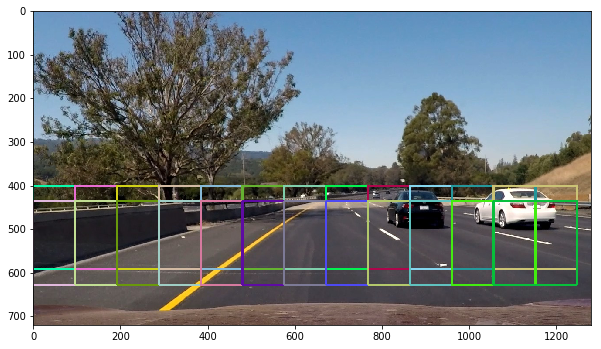

In [29]:
 # Test Image 1
svc = joblib.load('./SVC/svc_2.pkl') 
# X_scaler = joblib.load('./SVC/X_scaler.pkl') 

test_img = mpimg.imread('./test_images/test6.jpg')

colorspace = 'RGB2YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
Orient = 11
Pix_per_cell = 16
Cell_per_block = 2
Hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


bbox = []

ystart = 400
ystop = 600
scale = 3.0
bbox.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=0.6, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=True))
ystart = 435
ystop = 650
scale = 3.0
bbox.append(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(16,16), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=0.6, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=True))

bbox_list = [item for sublist in bbox for item in sublist] 
test_img_bbox = draw_boxes(test_img, bbox_list, color='random', random_color=True, thickness=3)
plt.figure(figsize=(10,10))
plt.imshow(test_img_bbox)
print('Number of boxes: ', len(bbox_list))

# Use found searching regions to detect vehicles from test_images

In [41]:
def show_detect_area(img, show_bbox=False):

    rectangles = []

    colorspace = 'RGB2YUV'
    Orient = 11
    Pix_per_cell = 16
    Cell_per_block = 2
    Hog_channel = 'ALL'
    prob = 0.9

    ystart = 400
    ystop = 465
    scale = 1.0
    bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=show_bbox)
    if len(bbox) != 0:
        rectangles.append(bbox)
        
    ystart = 415
    ystop = 488
    scale = 1.0
    bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=show_bbox)
    if len(bbox) != 0:
        rectangles.append(bbox)
        
    ystart = 400
    ystop = 496
    scale = 1.6
    bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=show_bbox)
    if len(bbox) != 0:
        rectangles.append(bbox)
        
    ystart = 400
    ystop = 510
    scale = 1.6
    bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=show_bbox)
    if len(bbox) != 0:
        rectangles.append(bbox)
        
    ystart = 400
    ystop = 550
    scale = 2.0
    bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=show_bbox)
    if len(bbox) != 0:
        rectangles.append(bbox)
        
    ystart = 430
    ystop = 580
    scale = 2.0
    bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=show_bbox)
    if len(bbox) != 0:
        rectangles.append(bbox)
        
    ystart = 400
    ystop = 600
    scale = 3.0
    bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=show_bbox)
    if len(bbox) != 0:
        rectangles.append(bbox)
        
    ystart = 435
    ystop = 650
    scale = 3.0
    bbox = find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=show_bbox)
    if len(bbox) != 0:
        rectangles.append(bbox)

    
    heatmap_img = np.zeros_like(img[:,:,0])
    
    if len(rectangles) != 0:
        for bbox in rectangles:
            heatmap_img = add_heat(heatmap_img, bbox)

        heatmap_img = apply_threshold(heatmap_img, 1)
        labels = label(heatmap_img)
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
    else:
        draw_img = img
        
    return draw_img

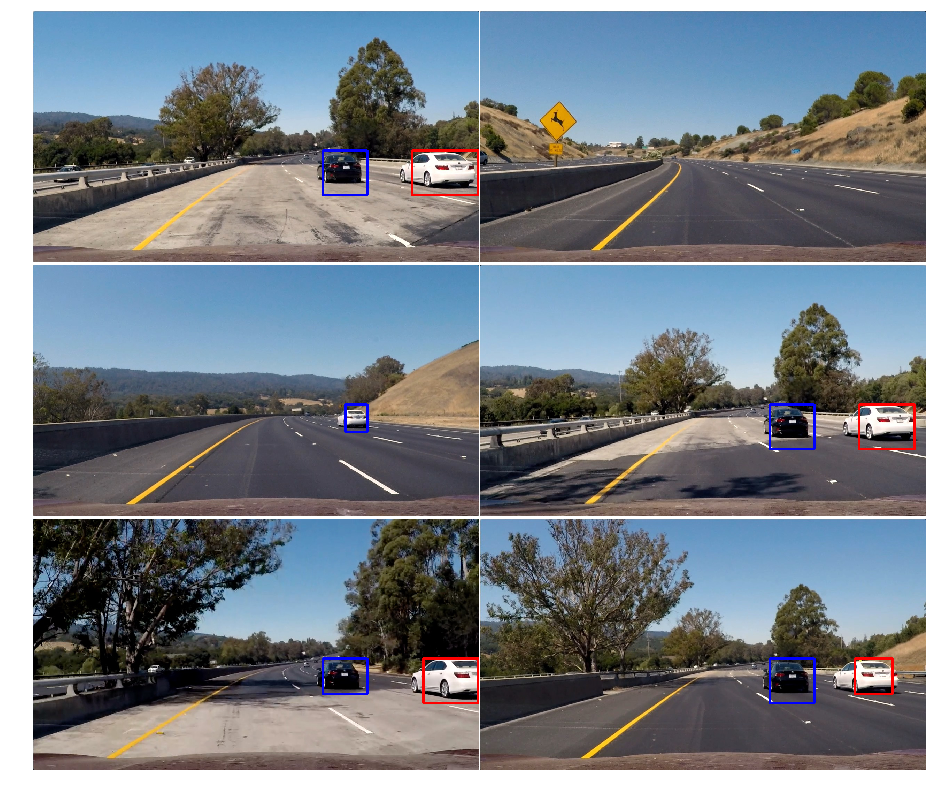

In [42]:
# img = mpimg.imread('./test_images/test6.jpg')
imgs = glob.glob('./test_images/*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()
    
svc = joblib.load('./SVC/svc_2.pkl') 
# X_scaler = joblib.load('./SVC/X_scaler.pkl') 

for ii, img_path in enumerate(imgs):
    img = mpimg.imread(img_path)
    
    draw_img = show_detect_area(img)
    
    axs[ii].imshow(draw_img)
    axs[ii].axis('off')
    
    mpimg.imsave('./output_images/detected_test_image_{}.jpg'.format(ii+1), draw_img)

# Detect Vehicles from videos

In [22]:
def process_frame(img):

    rectangles = []

    colorspace = 'RGB2YUV'
    Orient = 11
    Pix_per_cell = 16
    Cell_per_block = 2
    Hog_channel = 'ALL'
    prob = 0.9

    ystart = 400
    ystop = 465
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=False))
#     ystart = 416
#     ystop = 480
#     scale = 1.0
    ystart = 415
    ystop = 488
    scale = 1.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=False))
    ystart = 400
    ystop = 496
    scale = 1.6
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=False))
    ystart = 400
    ystop = 510
    scale = 1.6
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=False))
    ystart = 400
    ystop = 550
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=False))
    ystart = 430
    ystop = 580
    scale = 2.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=False))
    ystart = 400
    ystop = 600
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=False))
    ystart = 435
    ystop = 650
    scale = 3.0
    rectangles.append(find_cars(img, ystart, ystop, scale, svc, X_scaler, conv=colorspace, orient=Orient, pix_per_cell=Pix_per_cell, 
                      cell_per_block=Cell_per_block, hog_channel=Hog_channel, spatial_size=(32,32), hist_bins=32, hist_range=(0,256), window=64,
                      pred_proba_threshold=prob, spatial_feature=False, hist_feature=False, hog_feature=True, 
                      show_all_rectangles=False))

    rectangles = [item for sublist in rectangles for item in sublist] 
    
    if len(rectangles) > 0:
        heatmaps.append(rectangles)
#         averaged_heat = sum(heatmaps)
#     else: # If you didn't detect anything from the heatmap
#         averaged_heat = np.zeros_like(img[:,:,0])
        
    heatmap_img = np.zeros_like(img[:,:,0])
    
    for bbox in heatmaps:
        
        heatmap_img = add_heat(heatmap_img, bbox)
    
#     heatmap_img = apply_threshold(heatmap_img, 1)
    heatmap_img = apply_threshold(heatmap_img, 5 + len(heatmaps)//2)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

# Test on videos

In [43]:
# !mkdir test_videos_output

# Test on test video with small size

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

# Creat deque to save detected results over several frames
heatmaps = collections.deque(maxlen=15)
# Set parameters
svc = joblib.load('./SVC/svc_2.pkl') 
# X_scaler = joblib.load('./SVC/X_scaler.pkl') 


video_output = './test_videos_output/output_test_video.mp4'
project_video = VideoFileClip("./test_video.mp4")
#     processed_video = project_video.fl_image(detect_vehicles_from_video) #NOTE: this function expects color images!!
processed_video = project_video.fl_image(process_frame) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/output_test_video.mp4
[MoviePy] Writing video ./test_videos_output/output_test_video.mp4



 97%|█████████▋| 38/39 [00:53<00:01,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/output_test_video.mp4 

CPU times: user 32.4 s, sys: 2 s, total: 34.4 s
Wall time: 56.6 s


In [24]:
# !mkdir test_videos_output

# Test on test video with small size

## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)

# Creat deque to save detected results over several frames
heatmaps = collections.deque(maxlen=15)
# Set parameters
svc = joblib.load('./SVC/svc_2.pkl') 

video_output = './test_videos_output/output_project_video.mp4'
project_video = VideoFileClip("./project_video.mp4")
processed_video = project_video.fl_image(process_frame) #NOTE: this function expects color images!!
%time processed_video.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./test_videos_output/output_project_video.mp4
[MoviePy] Writing video ./test_videos_output/output_project_video.mp4



 12%|█▏        | 152/1261 [01:54<14:00,  1.32it/s]


 24%|██▍       | 303/1261 [03:52<12:25,  1.29it/s]


 36%|███▌      | 454/1261 [05:49<10:24,  1.29it/s]


 48%|████▊     | 605/1261 [07:45<08:22,  1.31it/s]


 60%|█████▉    | 756/1261 [09:43<06:08,  1.37it/s]


 72%|███████▏  | 907/1261 [11:39<04:25,  1.34it/s]


 84%|████████▍ | 1057/1261 [13:43<03:01,  1.12it/s]


 96%|█████████▌| 1205/1261 [15:39<00:42,  1.31it/s]


100%|█████████▉| 1260/1261 [16:21<00:00,  1.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./test_videos_output/output_project_video.mp4 

CPU times: user 15min 8s, sys: 1min 2s, total: 16min 10s
Wall time: 16min 22s
